## Aqualab Validation Study: Model Test

After our discussion with Shari, we came to several conclusions about the current state of the Aqualab analysis:



1.   There is a distinction between jobTasksCompleted and jobCompleted, and the choice of which feature to use will ultimately yield different results.
2.   Converting jobTasksCompleted from a bucketed boolean to a percent value between 0 and 1 could potentially yield further insights
3. It's interesting to see that the initial naive decision tree construction points to the same features that came about via the dimensional reduction via logit regression- what does the AUC look like for this model after we tune the hyperparameters?
4. We should see what the cumulative EMA scores look like when used in the analysis, however, because argumentation related questions are most extensive and difficult on the survey, these scores might be doing the best job at yielding "successes" and failures"

As a reminder, these are the features we have access to:





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats
import statistics

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import graphviz

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import statsmodels.api as sm

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from sklearn.metrics import f1_score


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=0ec8ce635ad1440d9b302185c0a8483827940ebaabae130eac1503bae4c4744e
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=2d7e45f1261686af14ac6cbc937df85b5d428c8db9d57b68565a4ed6d1630662
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
  Preparing metadata (setup.py) ... done
  Created wheel for pypair: filename=pypair-3.0.9-py3-none-any.whl size=24526 sha256=a96199730993849ecf20e3a7e5a8143f253cdc26102dda41dd19caeb63e27495
  Stored in directory: /root/.cache/pip/wheels/27/d8/78/bc27988fe8ef1086879ea558f8c9bc03d8c51e4ff2c1ee8344
Successfully built pypair
     ━━━━━━

In [ ]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)



1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

# Meeting Review

Let's start by making updates to our analysis and the contents of the analysis based on what we discussed.

### Preprocessing/ previs

When looking at the previs this time, notice that the distribution for argumentation scores seems to suggest that few players achieve a high rating in this category. This is why our current bucketing scheme of 75th percentile could be working best for argumentation, because there is a higher bar to clear in terms of success as compared to the other categories.

In [ ]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")

player_complexity['Experiment_score_max_5'] = player_complexity['Experiment_score_max_5'].round().astype(int)
player_complexity['Modeling_score_max_5'] = player_complexity['Modeling_score_max_5'].round().astype(int)
player_complexity['Argument_score_max_4'] = player_complexity['Argument_score_max_4'].round().astype(int)

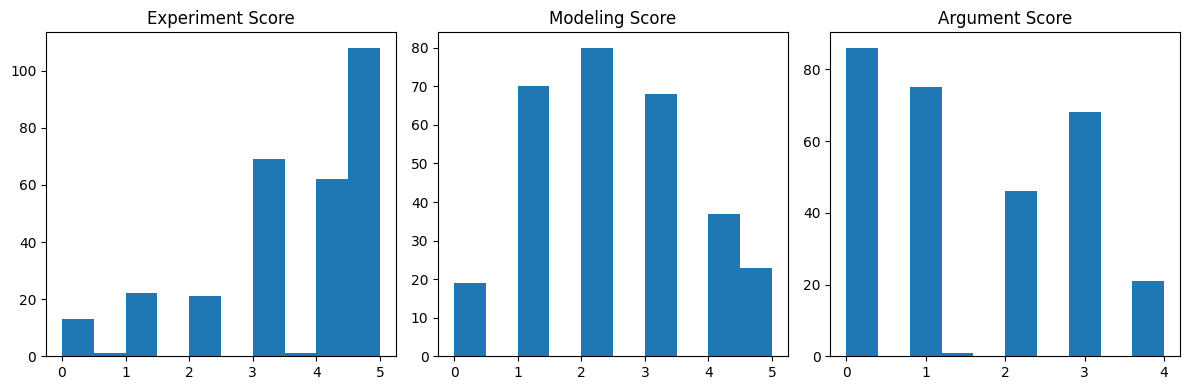

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

In [ ]:
df = player_complexity

# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_2'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Experiment_score_max_5']) else 1)

####################
df['Modeling_score_max_5_binary_bucket_3'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 75) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_3'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 75) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_3'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 75) else 1)


########################
df['Modeling_score_max_5_bucket_4'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 25) else (1 if x < np.percentile(df['Modeling_score_max_5'], 50) else (2 if x < np.percentile(df['Modeling_score_max_5'], 75) else 3)))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_bucket_4'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 25) else (1 if x < np.percentile(df['Argument_score_max_4'], 50) else (2 if x < np.percentile(df['Argument_score_max_4'], 75) else 3)))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_bucket_4'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 25) else (1 if x < np.percentile(df['Experiment_score_max_5'], 50) else (2 if x < np.percentile(df['Experiment_score_max_5'], 75) else 3)))

<ipython-input-6-65277f1397e7>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)
<ipython-input-6-65277f1397e7>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)
<ipython-input-6-65277f1397e7>:10: PerformanceWarning: DataFrame is high

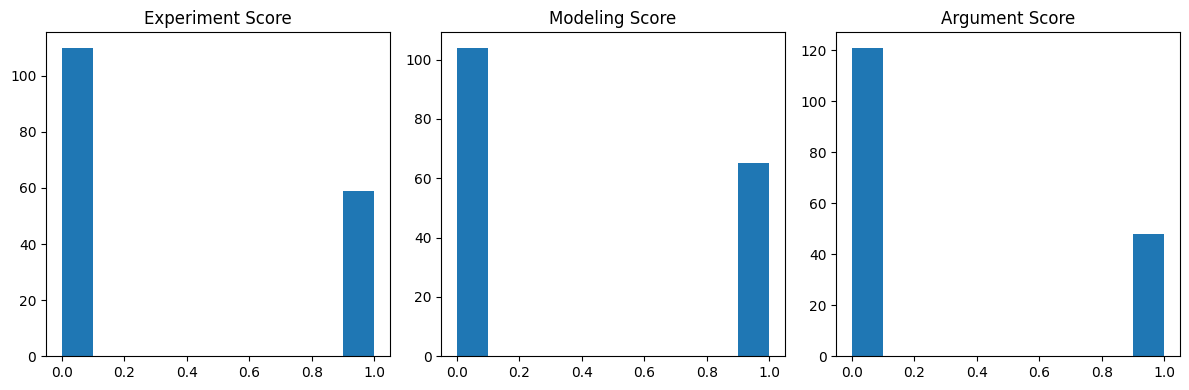

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_binary_bucket_3']
modeling_score = df['Modeling_score_max_5_binary_bucket_3']
argument_score = df['Argument_score_max_4_binary_bucket_3']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

## 1: There is an important distinction between jobTasksCompleted and JobsAttempted-num-completes

We will assume for now that the reason the feature is called JobsAttempted-num-completes is because a player can go back and do a job again. For now this assumption is fine because it seems this feature value is either 1 or 0. Before converting our jobTasksCompleted back to an ordinal and then to a percent value, let's see what we get using JobsAttempted-num-completes.



### Rerun analysis with JobsAttempted-num-**completes**

#### 1. Corr coeffs

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_3', 'Modeling_score_max_5_binary_bucket_3', 'Argument_score_max_4_binary_bucket_3']

i = 0
for job in df:
  if "num-completes" in job:
    i +=1
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')
print(i)


job13_JobsAttempted-num-completes: 0.25968411659493656, 0.0006507682861722816, Argument_score_max_4_binary_bucket_3
job20_JobsAttempted-num-completes: 0.20189796085181239, 0.008479421239586832, Modeling_score_max_5_binary_bucket_3
job32_JobsAttempted-num-completes: 0.2018979608518124, 0.008479421239586832, Modeling_score_max_5_binary_bucket_3
57


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


At this point we're back in a similar position, where the only job that passes the benjamini-hochberg procedure is job13. We won't re-run further logit analysis as it's mostly redundant.


## 2: Using a percent/continuous value for jobTasksCompleted could yield more information than binary against binary in logit models

It seems like the percent-complete feature is incorrect, as all our values for job12 are either 0 or 100, but clearly some players completed a partial number of tasks. Instead let's try converting jobTasksCompleted to a percent value ourselves.

In [ ]:
df_new = df

for job in df_new:
  if "TasksCompleted" in job:
    max = df_new[job].max()
    df_new[job] = df_new[job].apply(lambda x: x/df_new[job].max() if x !=0 and df_new[job].max() != 0 else x/100)

df_new[['job12_JobTasksCompleted']]




,job12_JobTasksCompleted
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
164,0.0
165,0.0
166,0.0
167,0.0


### Rerun analysis with percent value for JobTasksCompleted
Originally our logit models were reversed because we had an ordinal response variable and a binary explanatory variable. Now since we have an ordinal explanatory variable and a (bucketed) response variable, we can properly use our logit models the way they were intended.

#### corr coeffs

In [ ]:

correlation_columns = ['Argument_score_max_4_binary_bucket_3']

i = 0
for job in df_new:
  if "TasksCompleted" in job:
    for corr in correlation_columns:
      i += 1
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')
print(i)


job1_JobTasksCompleted: 0.16390963886232526, 0.03321834713970481, Argument_score_max_4_binary_bucket_3
job12_JobTasksCompleted: 0.22102996387056909, 0.003878612362366899, Argument_score_max_4_binary_bucket_3
job13_JobTasksCompleted: 0.28694893612833045, 0.00015525478511295868, Argument_score_max_4_binary_bucket_3
job20_JobTasksCompleted: 0.15155444566227677, 0.049187554060140616, Argument_score_max_4_binary_bucket_3
job30_JobTasksCompleted: 0.16088860354236462, 0.03664817492369413, Argument_score_max_4_binary_bucket_3
job32_JobTasksCompleted: 0.23033997432687828, 0.0025883663182104427, Argument_score_max_4_binary_bucket_3
57


Using Benjamini Hochberg with a sample size m=51 (since we are now only considering argument scores in the scope of our larger analysis), and an FDR of 0.1, all of these correlations are below alpha. If we use a more stringent measure(such as FDR = 0.05), we only retain job12 and job32 as valid correlations. An argument can be made for many different benjamini-hochberg parameters and these will have to be discussed later- however, the fact that job13 is eliminated by an FDR of 0.1 when we can cross validate the importance of job13 in a random-forest decision tree seems to indicate that excluding this job could potentially be a type 2 error. Given the relatively small sample size n and the focus on argumentation specifically, I believe parameters of m=51 and FDR=0.1 to be appropriate.

#### Logit models
With our data now correctly oriented to have a binary x and ordinal y, we can now take a real look at our logit models. Let's see how they look for the statistically significant correlations we identified:

Optimization terminated successfully.
         Current function value: 0.575085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573414
         Iterations 5


Text(0, 0.5, 'Argument_score_max_4_binary_bucket_3')

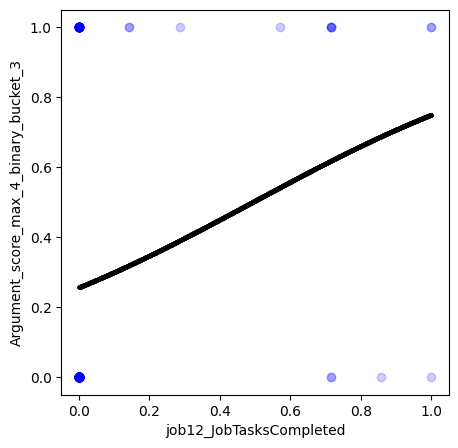

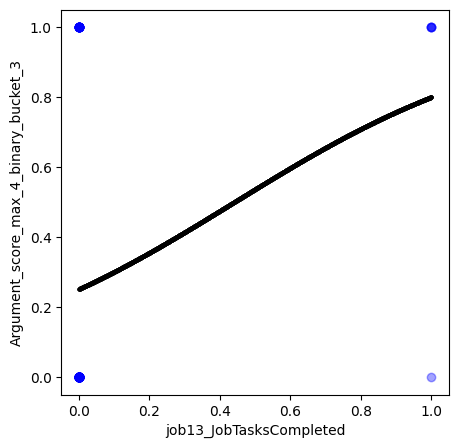

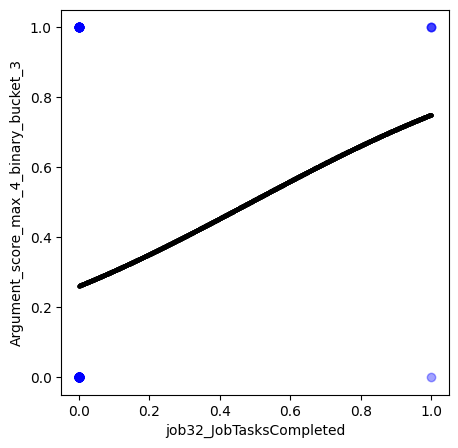

In [ ]:
res = 'job12_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


########################



res = 'job13_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


########################


res = 'job32_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

In [ ]:

X = df_new[['job13_JobTasksCompleted']]
y = df_new['Argument_score_max_4_binary_bucket_3'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)


log_reg = sm.Logit(y_train, X_train).fit()

log_reg.summary()

NameError: ignored

As we can see, we're now looking at logistic regression models that more clearly demonstrate a binary distinction between instances where a job is completed and not completed. As the completion of tasks moves from 0.0 -> 1.0, the probability of the argument score being higher for a player increases. We can see that this pattern emerges only in statistically significant correlations. In non-significant events (shortened for brevity):

Optimization terminated successfully.
         Current function value: 0.596038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594770
         Iterations 5


Text(0, 0.5, 'Argument_score_max_4_binary_bucket_3')

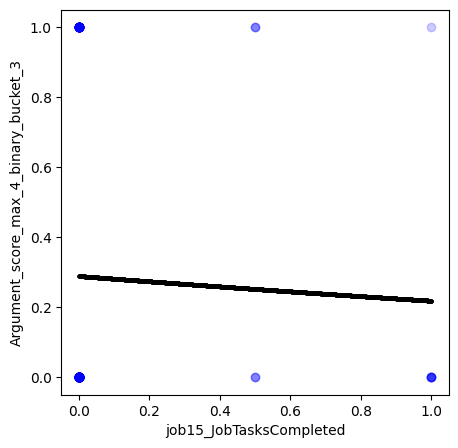

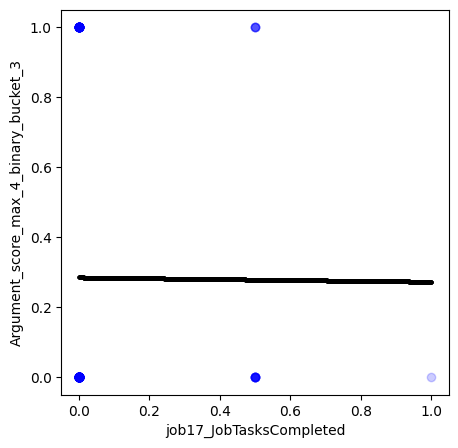

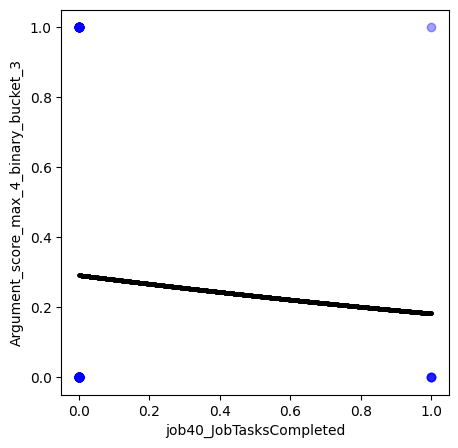

In [ ]:
########################



res = 'job15_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

########################



res = 'job17_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

########################



res = 'job40_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

At the most basic level, our statistically significant features emerge from instances where:

**When feature is true there is a lack of low outcomes and majority high outcomes**

**When feature is false there is normally distributed values**

If we need to do more feature engineering for this study in the future, it is worth keeping in mind that any worthwhile per-level features will be able to create this basic distinction.

#### Logit Model Analysis

While the visual graph of our logit models indicates good results, let's check the stats readouts.



In [ ]:
mod_prob = OrderedModel(df_new['Argument_score_max_4_binary_bucket_3'],
                        df_new[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.575085
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -97.189
Model:                                     OrderedModel   AIC:                             198.4
Method:                              Maximum Likelihood   BIC:                             204.6
Date:                                  Tue, 01 Aug 2023                                         
Time:                                          02:48:43                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.1613      0.837      2.581      0.010       0.520       3.802
0/1                         1.0634      0.182      5.827      0.000       0.706       1.421
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df_new['Argument_score_max_4_binary_bucket_3'],
                        df_new[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560289
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -94.689
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.6
Date:                                  Tue, 01 Aug 2023                                         
Time:                                          02:48:45                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.4765      0.811      3.052      0.002       0.886       4.067
0/1                         1.0902      0.183      5.965      0.000       0.732       1.448
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df_new['Argument_score_max_4_binary_bucket_3'],
                        df_new[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.573414
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -96.907
Model:                                     OrderedModel   AIC:                             197.8
Method:                              Maximum Likelihood   BIC:                             204.1
Date:                                  Tue, 01 Aug 2023                                         
Time:                                          02:48:47                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     2.1401      0.836      2.560      0.010       0.502       3.779
0/1                         1.0415      0.179      5.803      0.000       0.690       1.393
===========================================================================================
"""

Our logit models still offer encouraging results. Both the stats readouts and visualizations of the sigmoid curves show a promising relationship between the jobs in question and argumentation scores. There's a discrepancy between the numbering of jobs and what those jobs actually are in the JSON, so we'll come back to that.

# Model Construction

## Decision Trees

Let's see what outcomes we get from different configurations and parameters in decision trees.


### Decision Tree for all features
https://www.geeksforgeeks.org/decision-tree-implementation-python/

Split dataset:

In [ ]:
filtered_df = df.filter(like='TasksCompleted')

X_train, X_test, y_train, y_test = train_test_split(
          filtered_df, df_new['Argument_score_max_4_binary_bucket_3'], test_size = 0.3, random_state = 100)

Functions for training with gini index/entropy:

In [ ]:
def train_using_gini(X_train, X_test, y_train):

    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini

# Function to perform training with entropy.
def train_using_entropy(X_train, X_test, y_train):

    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 10, min_samples_leaf = 5)

    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy
def prediction(X_test, clf_object):

    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred

def calc_accuracy(y_test, y_pred):

    print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred))

    print ("Accuracy : ",
    accuracy_score(y_test,y_pred)*100)

    print("Report : ",
    classification_report(y_test, y_pred))

Predictions:

In [ ]:
###GINI TEST
clf_gini = train_using_gini(X_train, X_test, y_train)
y_pred_gini = prediction(X_test, clf_gini)
calc_accuracy(y_test, y_pred_gini)


### ENTROPY TEST
clf_entropy = train_using_entropy(X_train, X_test, y_train)
y_pred_entropy = prediction(X_test, clf_entropy)
calc_accuracy(y_test, y_pred_entropy)

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
Confusion Matrix:  [[35  5]
 [ 9  2]]
Accuracy :  72.54901960784314
Report :                precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.29      0.18      0.22        11

    accuracy                           0.73        51
   macro avg       0.54      0.53      0.53        51
weighted avg       0.69      0.73      0.70        51

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
Confusion Matrix:  [[35  5]
 [ 9  2]]
Accuracy :  72.54901960784314
Report :                precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.29      0.18      0.22        11

    accuracy                           0.73        51
   macro avg       0.54      0.53      0.53        51

### Decision Tree for selected features

In [ ]:
filtered_df = df.filter(like='TasksCompleted')

X_train, X_test, y_train, y_test = train_test_split(
          filtered_df[['job32_JobTasksCompleted', 'job12_JobTasksCompleted', 'job13_JobTasksCompleted']], df_new['Argument_score_max_4_binary_bucket_3'], test_size = 0.3, random_state = 100)

In [ ]:
###GINI TEST
clf_gini = train_using_gini(X_train, X_test, y_train)
y_pred_gini = prediction(X_test, clf_gini)
calc_accuracy(y_test, y_pred_gini)


### ENTROPY TEST
clf_entropy = train_using_entropy(X_train, X_test, y_train)
y_pred_entropy = prediction(X_test, clf_entropy)
calc_accuracy(y_test, y_pred_entropy)

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
Confusion Matrix:  [[38  2]
 [ 9  2]]
Accuracy :  78.43137254901961
Report :                precision    recall  f1-score   support

           0       0.81      0.95      0.87        40
           1       0.50      0.18      0.27        11

    accuracy                           0.78        51
   macro avg       0.65      0.57      0.57        51
weighted avg       0.74      0.78      0.74        51

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
Confusion Matrix:  [[38  2]
 [ 9  2]]
Accuracy :  78.43137254901961
Report :                precision    recall  f1-score   support

           0       0.81      0.95      0.87        40
           1       0.50      0.18      0.27        11

    accuracy                           0.78        51
   macro avg       0.65      0.57      0.57        51

78% is pretty good. Let's try recreating this result with another process.

### Decision Tree Reproduction

In [ ]:
filtered_df = df_new.filter(like='JobTasksCompleted')

X_train, X_test, y_train, y_test = train_test_split(
          filtered_df[['job32_JobTasksCompleted', 'job12_JobTasksCompleted', 'job13_JobTasksCompleted']], df_new['Argument_score_max_4_binary_bucket_3'], test_size = 0.3, random_state = 100)

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
clf_en.fit(X_train, y_train)
y_pred_en = clf_en.predict(X_test)



Model accuracy score with criterion entropy: 0.7647


[Text(0.6666666666666666, 0.875, 'x[0] <= 0.5\nentropy = 0.897\nsamples = 118\nvalue = [81, 37]'),
 Text(0.5, 0.625, 'x[2] <= 0.5\nentropy = 0.851\nsamples = 112\nvalue = [81, 31]'),
 Text(0.3333333333333333, 0.375, 'x[1] <= 0.357\nentropy = 0.811\nsamples = 108\nvalue = [81, 27]'),
 Text(0.16666666666666666, 0.125, 'entropy = 0.796\nsamples = 104\nvalue = [79, 25]'),
 Text(0.5, 0.125, 'entropy = 1.0\nsamples = 4\nvalue = [2, 2]'),
 Text(0.6666666666666666, 0.375, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.8333333333333334, 0.625, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]')]

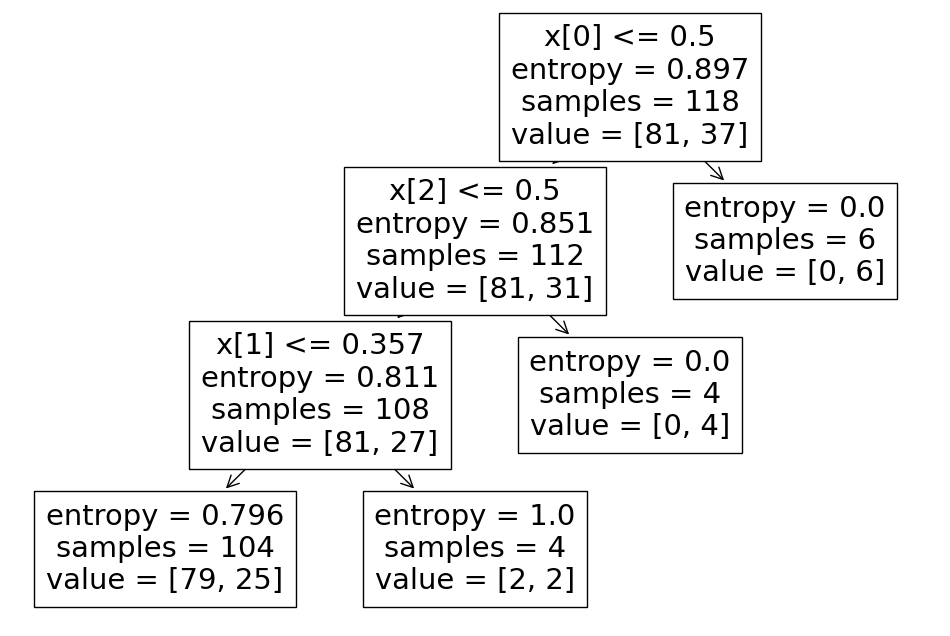

In [ ]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))
y_pred_train_en = clf_en.predict(X_train)
y_pred_train_en
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf_en.fit(X_train, y_train))


In [ ]:
cm = confusion_matrix(y_test, y_pred_en)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[37  3]
 [ 9  2]]


### Reproduction no. 3:
https://datagy.io/sklearn-decision-tree-classifier/

In [ ]:
DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0
)

X_train, X_test, y_train, y_test = train_test_split(
          filtered_df[['job32_JobTasksCompleted', 'job12_JobTasksCompleted', 'job13_JobTasksCompleted']], df_new['Argument_score_max_4_binary_bucket_3'], test_size = 0.3, random_state = 100)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(predictions)

print(accuracy_score(y_test, predictions))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
0.7647058823529411


## Random Forest Classifier
https://towardsdatascience.com/decision-trees-and-random-forests-explained-with-python-implementation-e5ede021a000

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [ ]:

X = filtered_df[['job32_JobTasksCompleted', 'job12_JobTasksCompleted', 'job13_JobTasksCompleted']]
y = df_new['Argument_score_max_4_binary_bucket_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)




In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rf.score

Accuracy: 0.803921568627451


<bound method ClassifierMixin.score of RandomForestClassifier()>

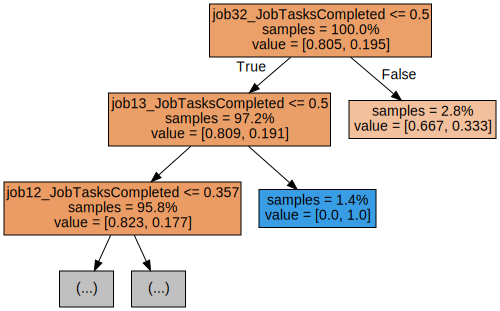

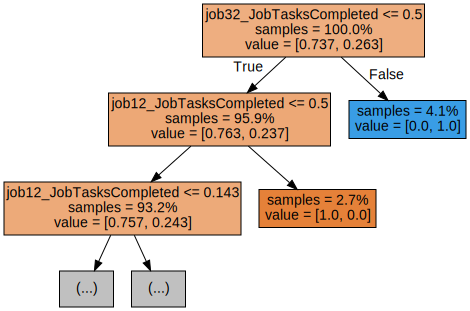

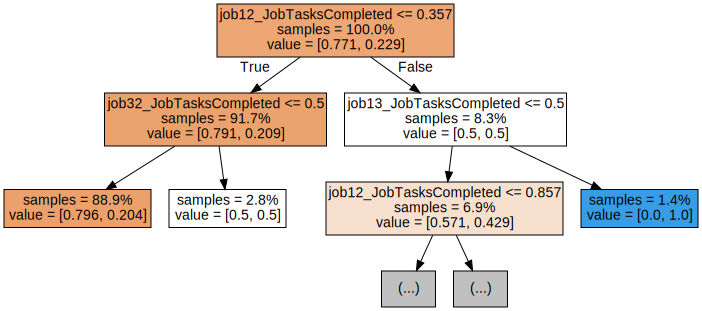

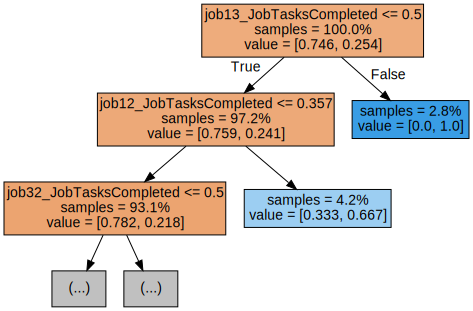

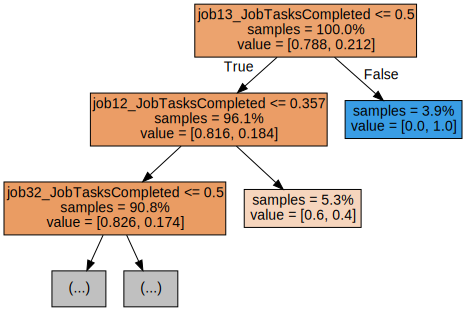

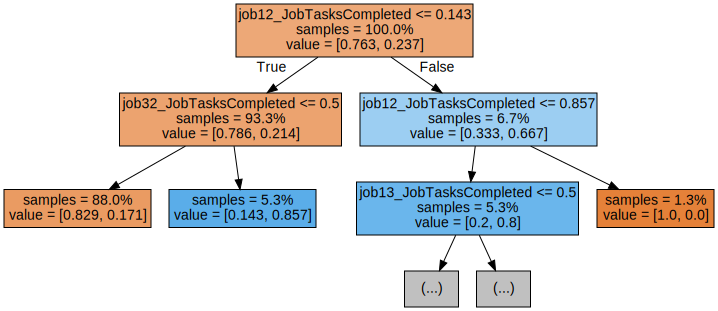

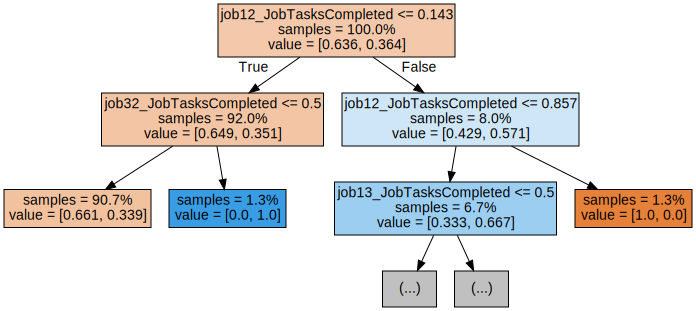

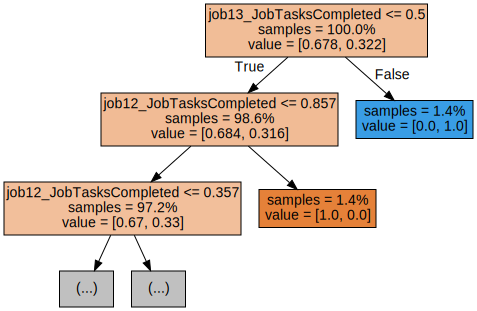

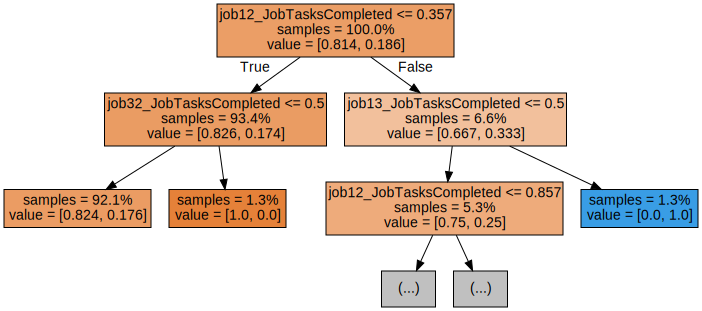

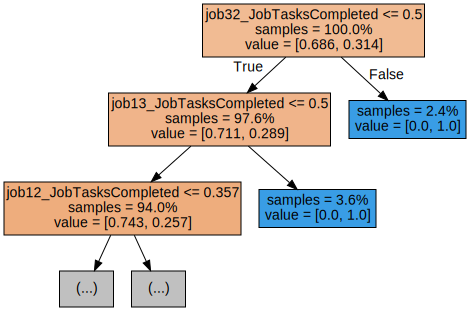

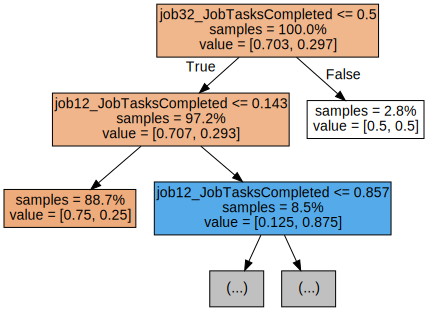

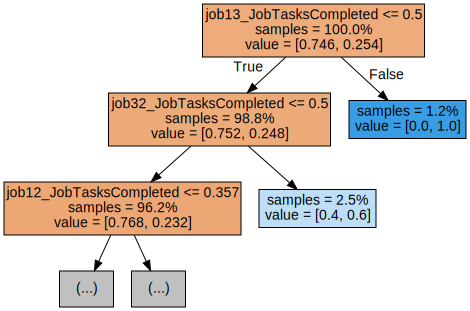

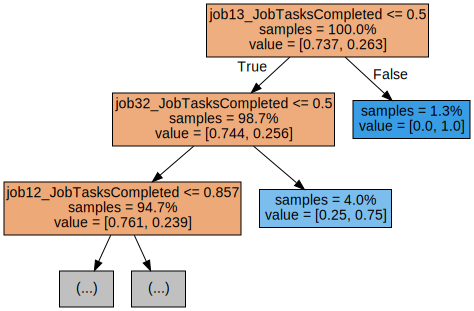

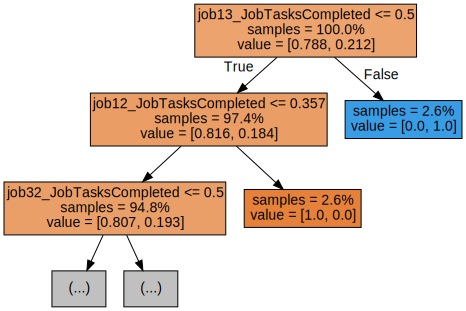

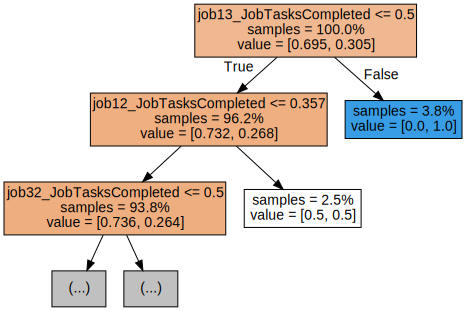

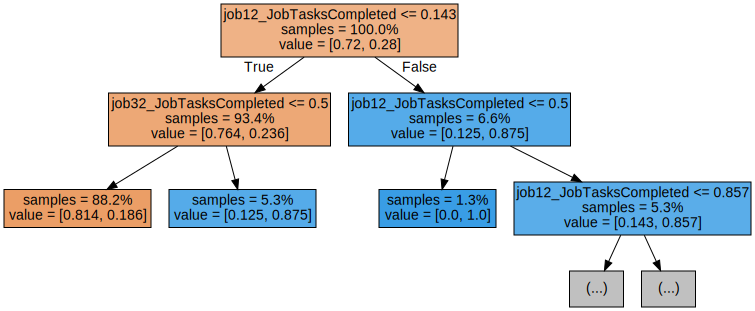

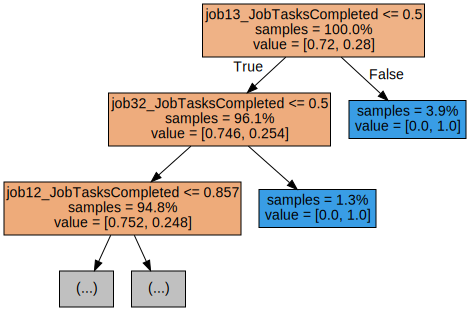

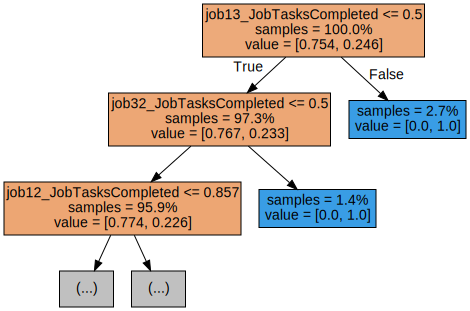

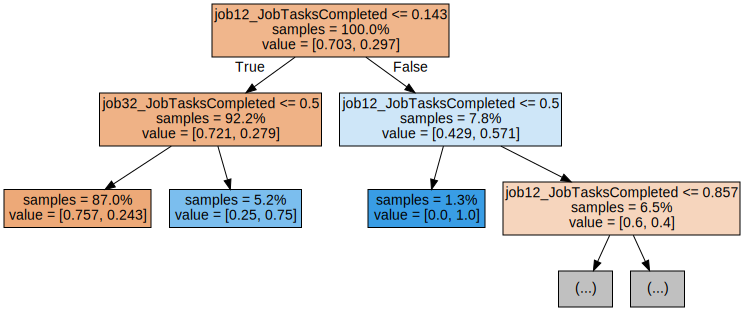

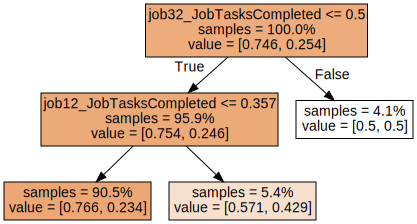

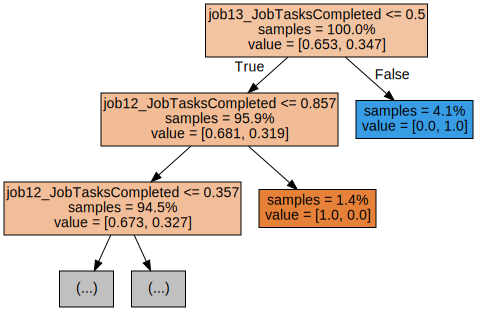

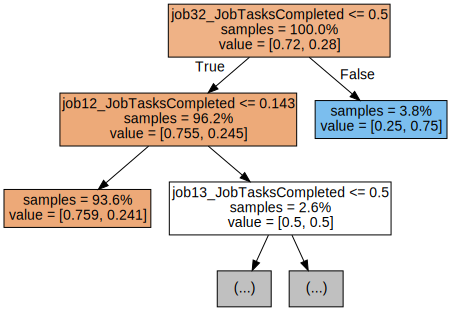

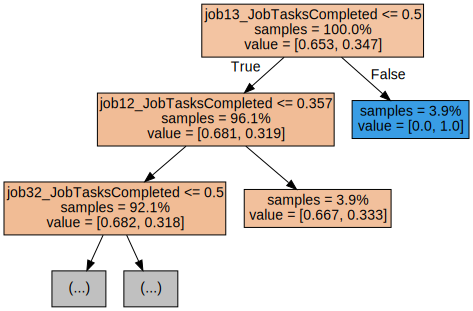

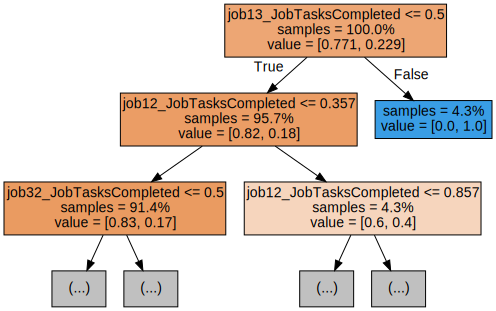

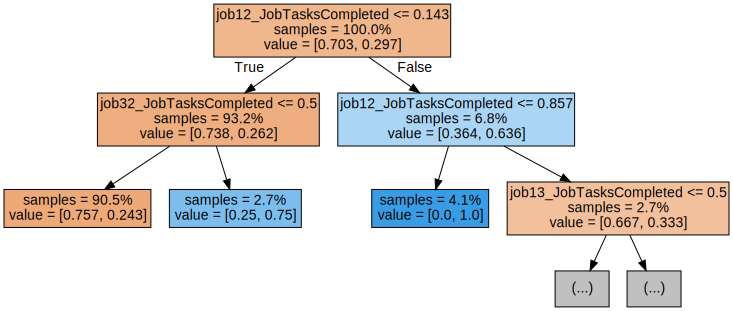

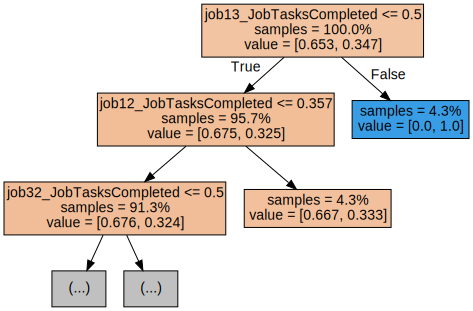

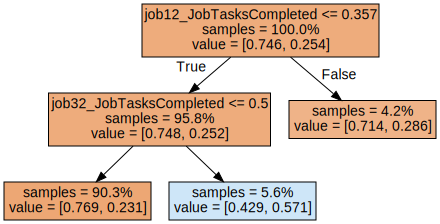

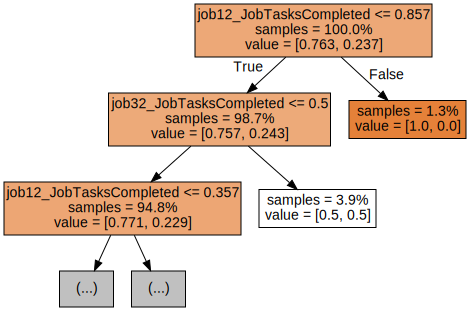

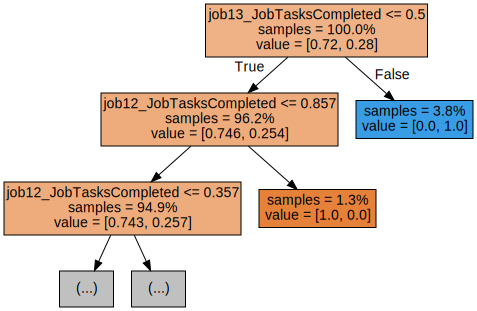

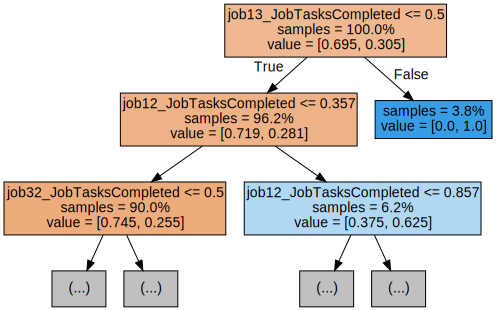

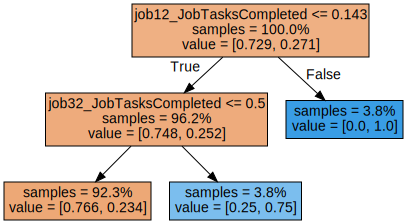

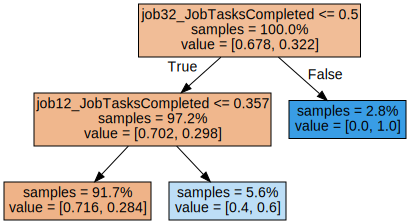

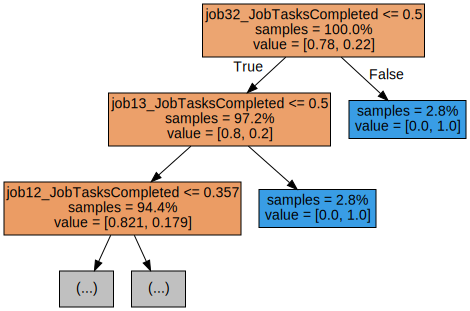

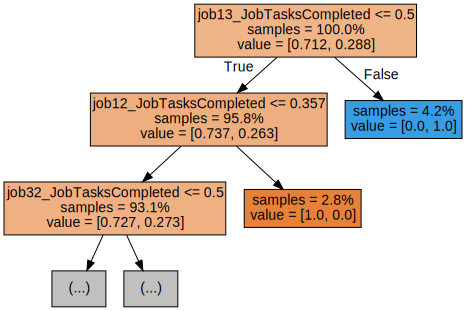

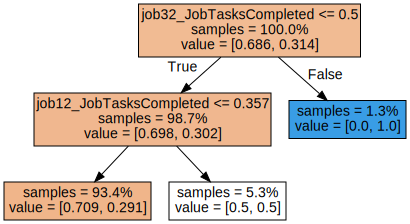

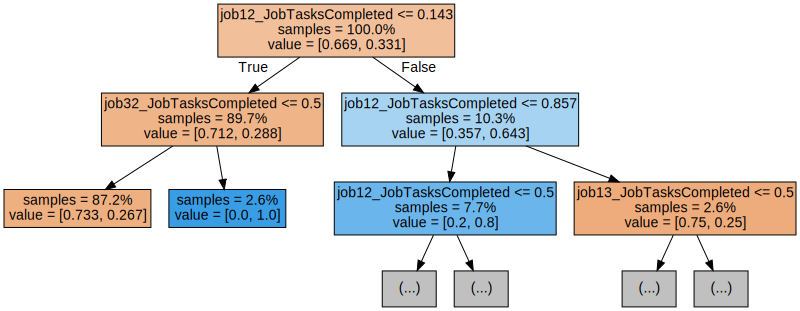

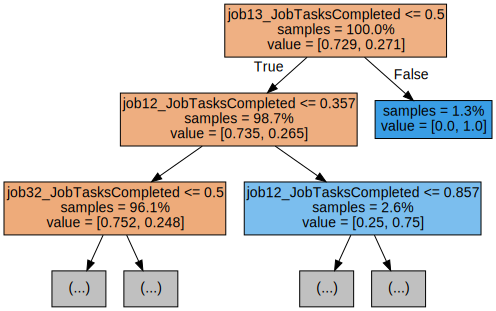

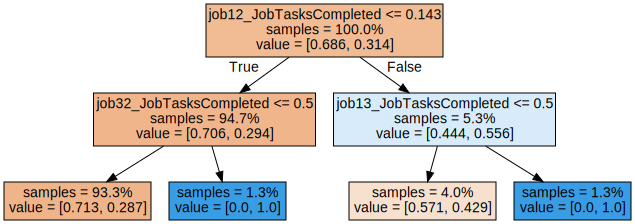

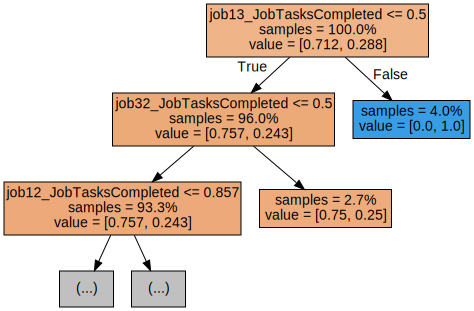

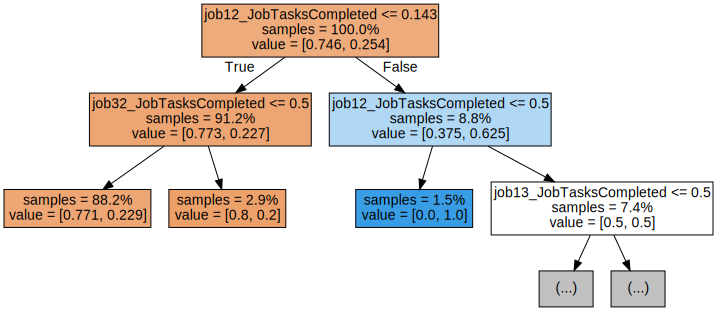

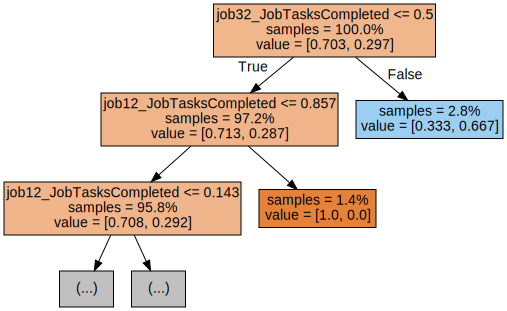

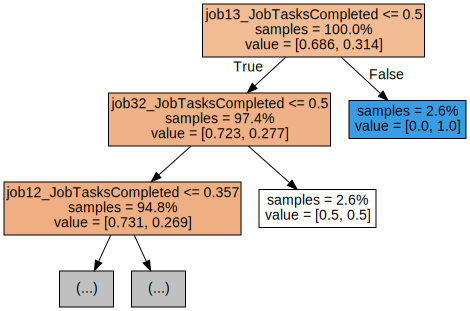

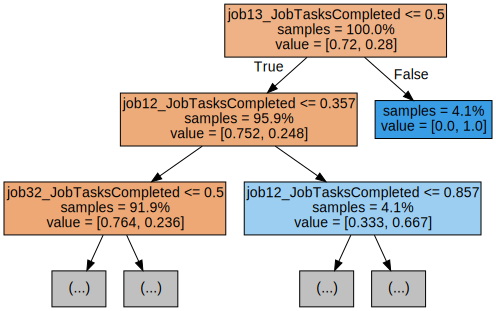

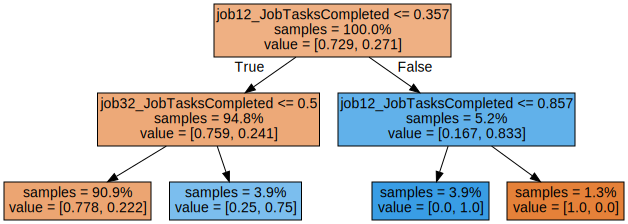

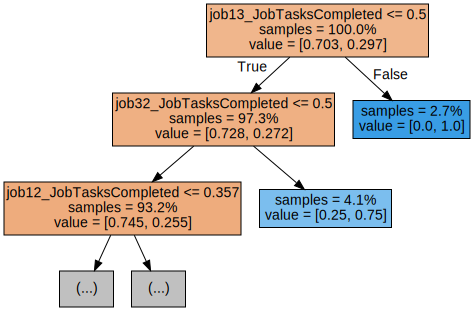

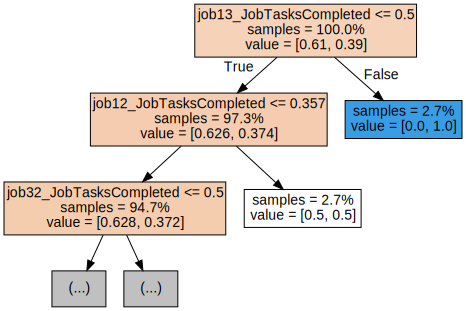

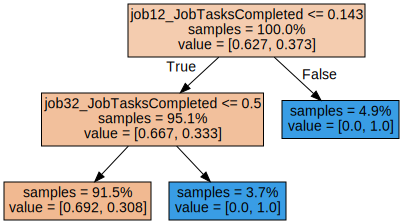

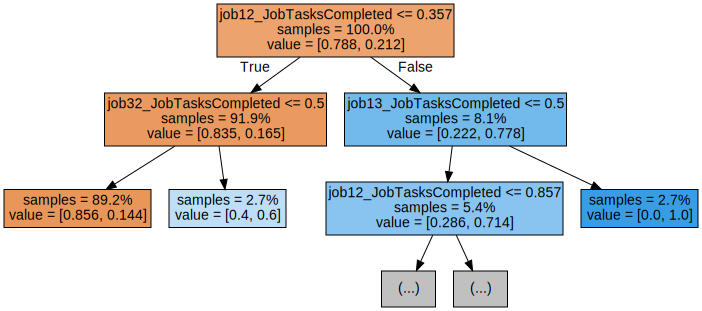

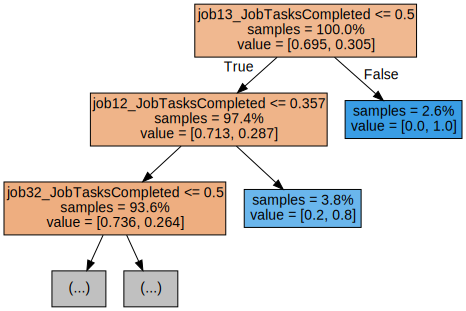

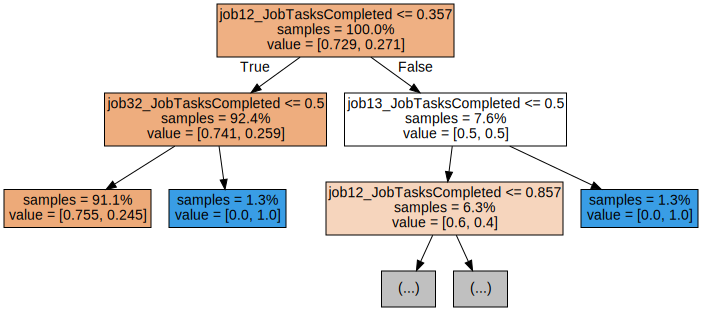

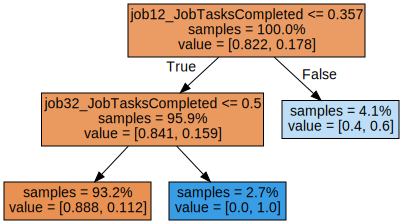

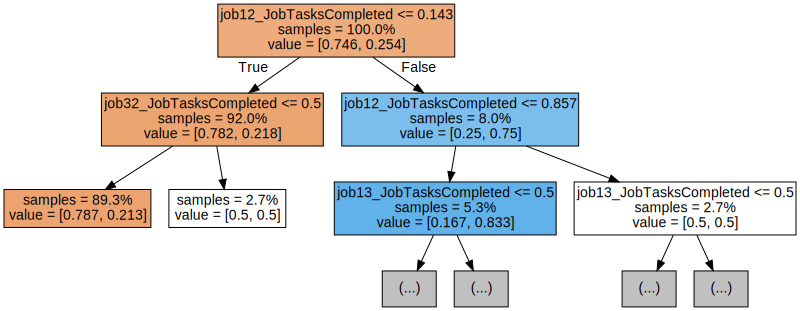

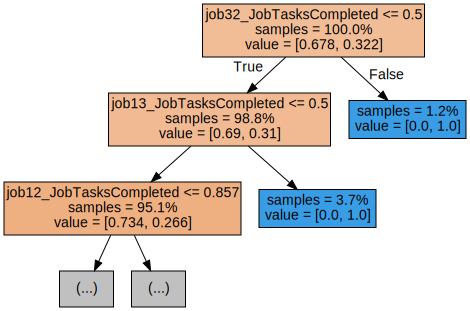

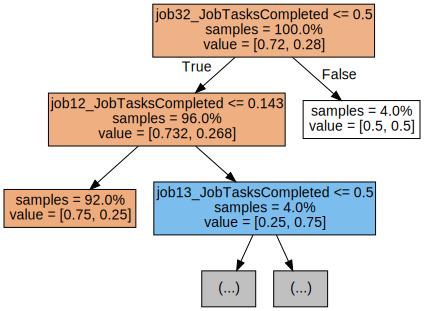

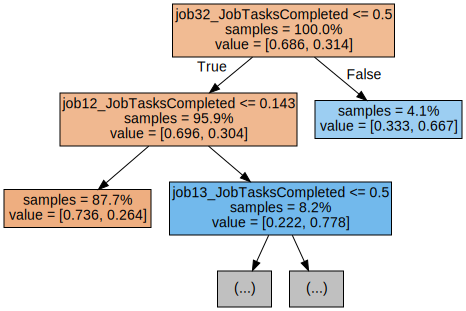

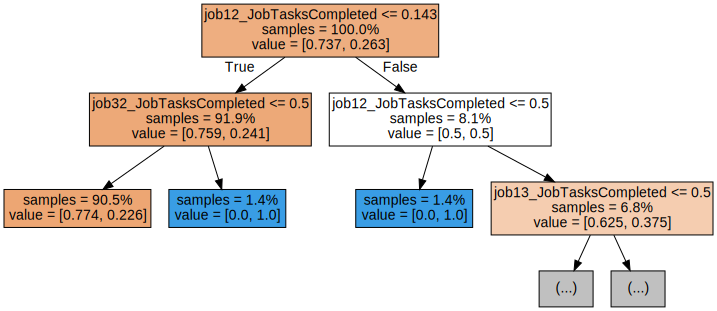

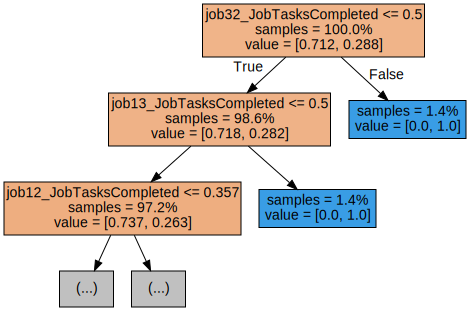

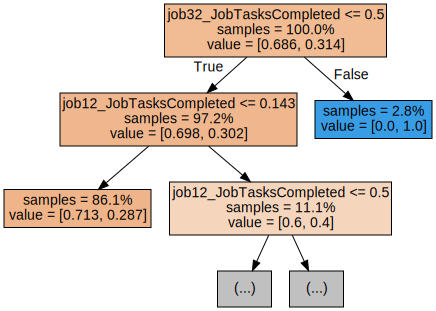

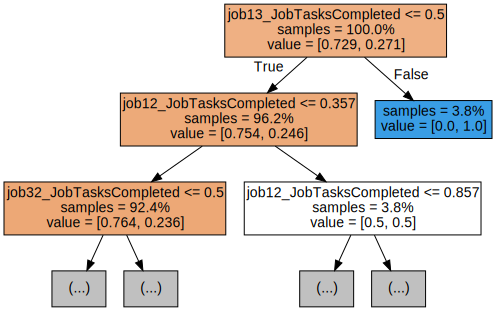

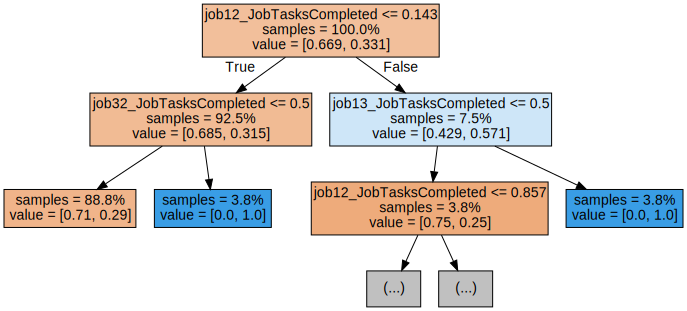

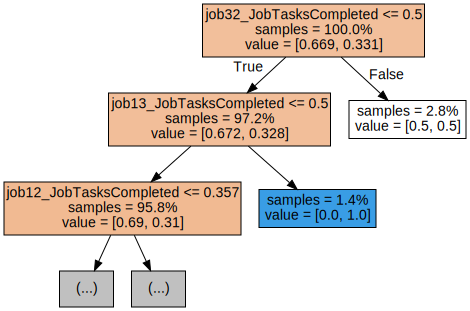

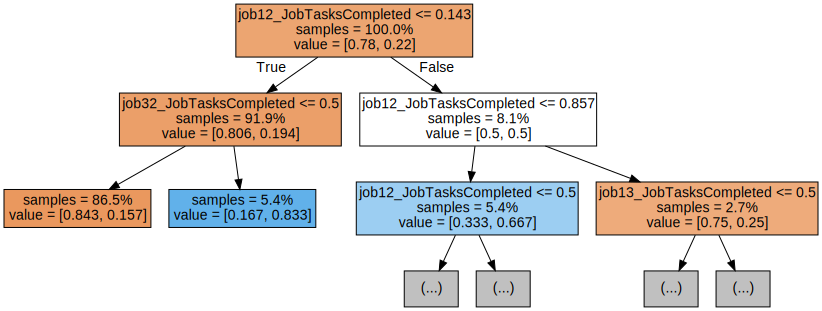

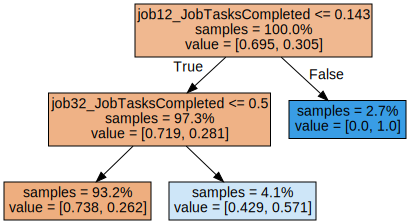

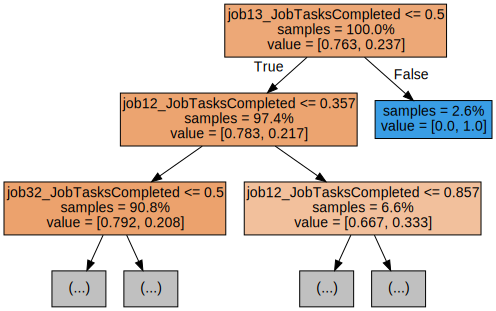

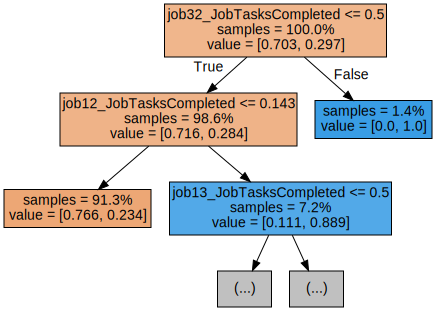

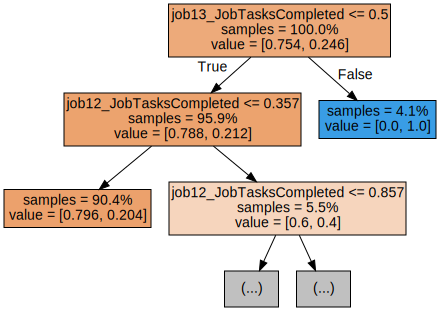

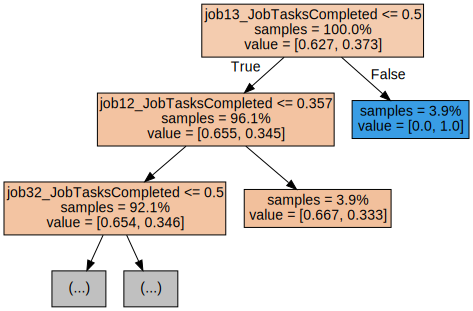

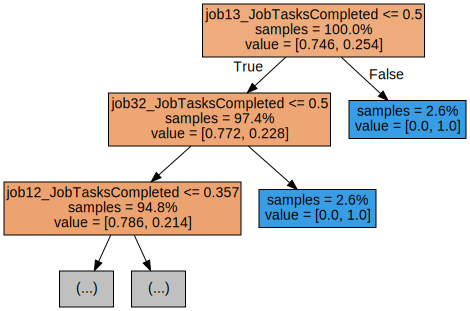

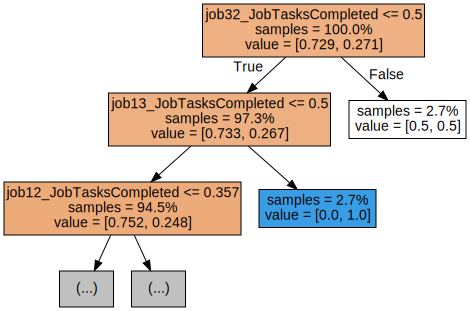

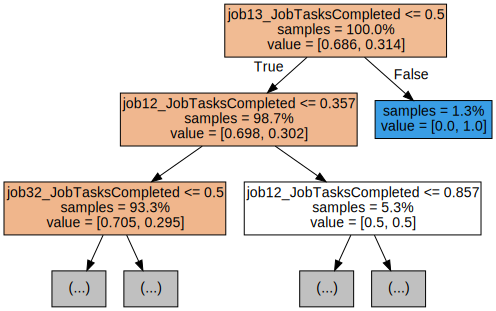

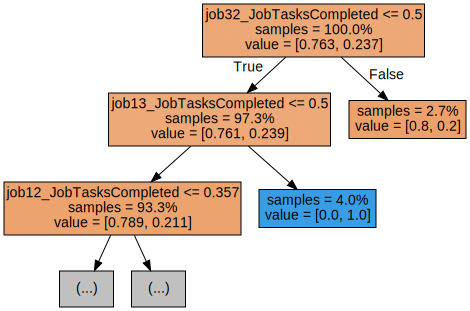

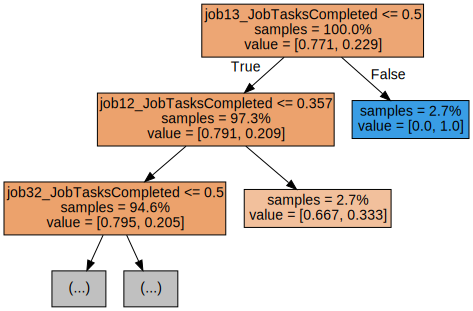

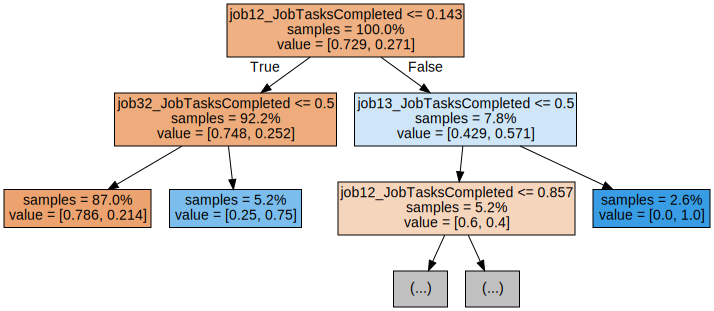

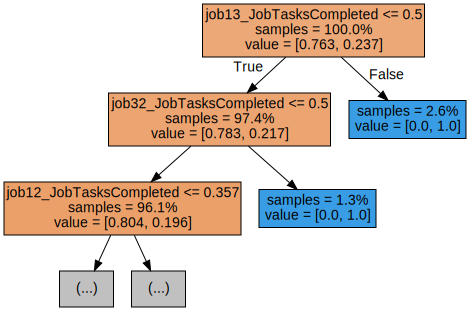

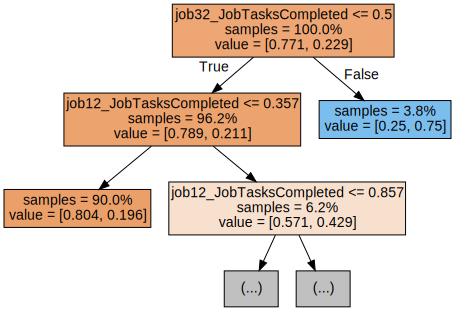

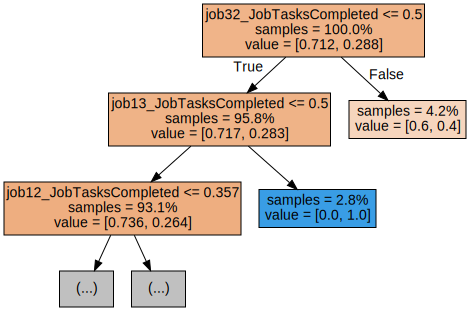

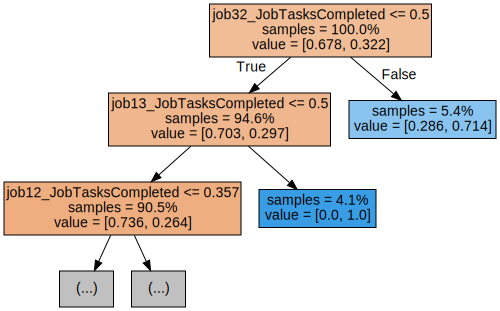

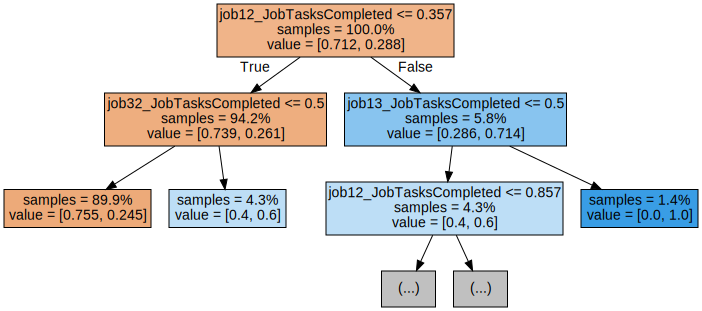

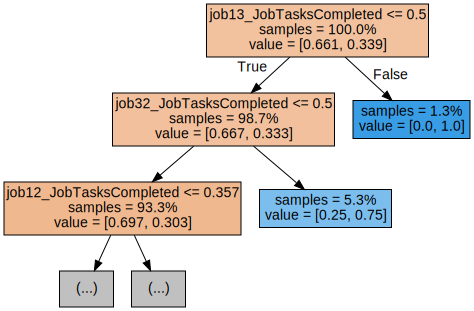

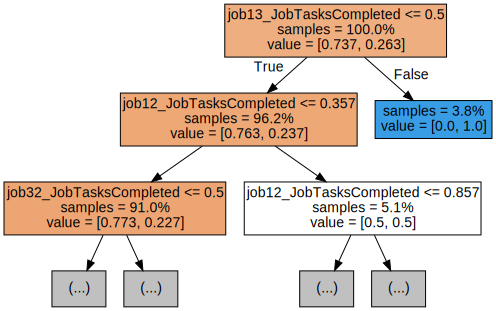

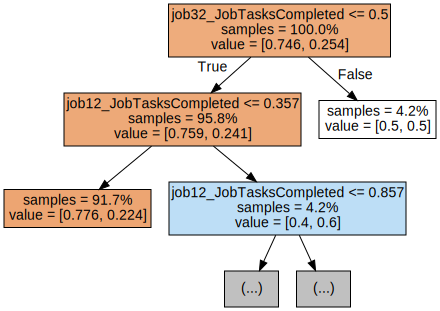

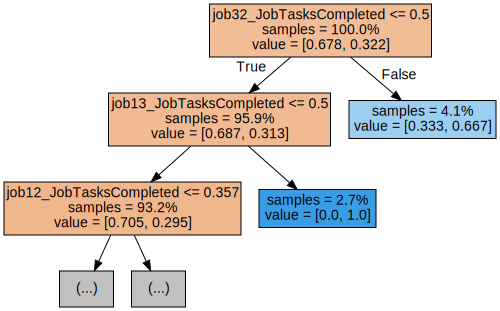

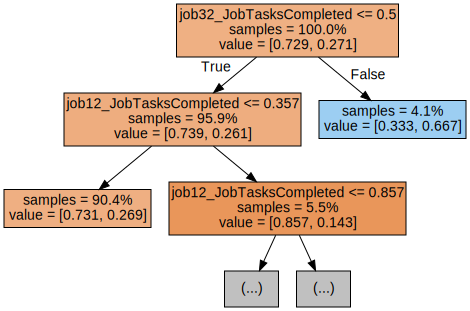

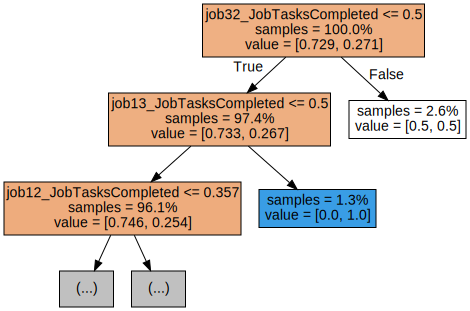

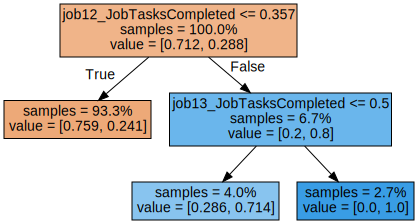

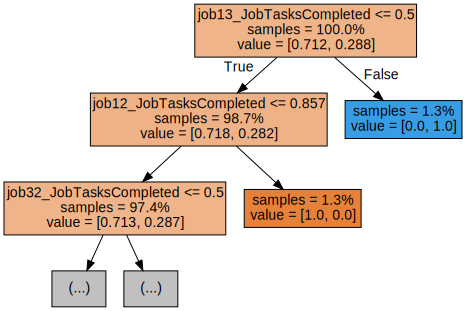

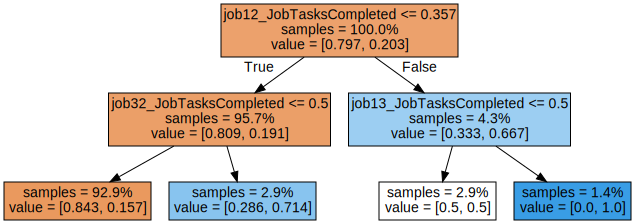

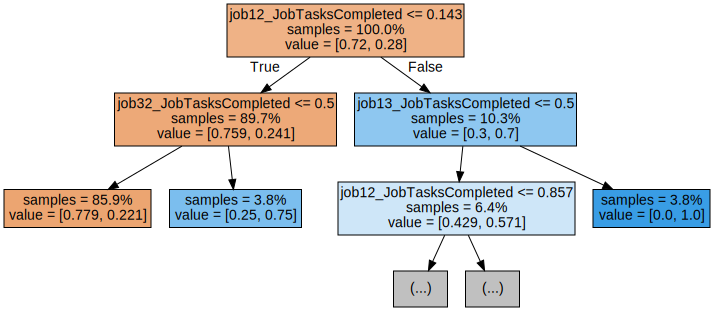

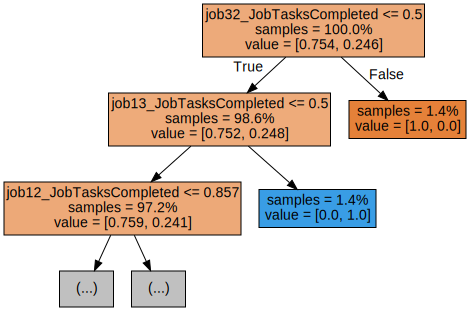

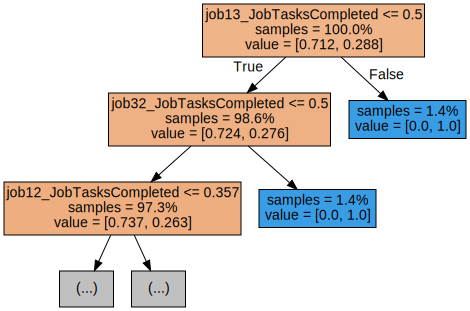

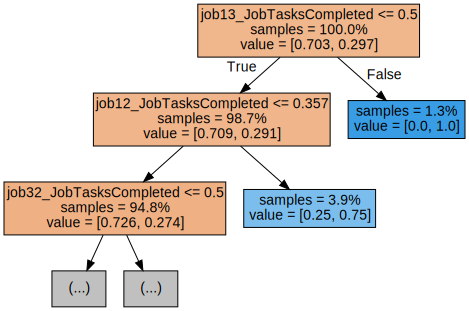

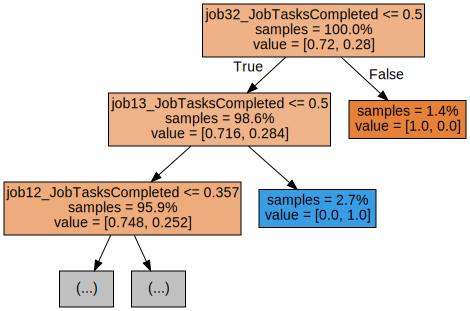

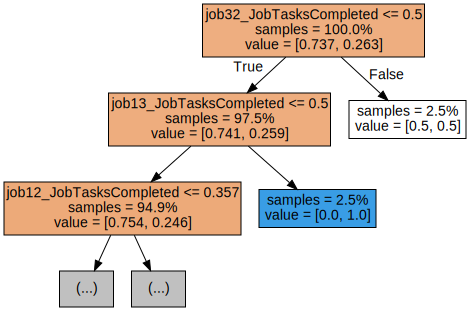

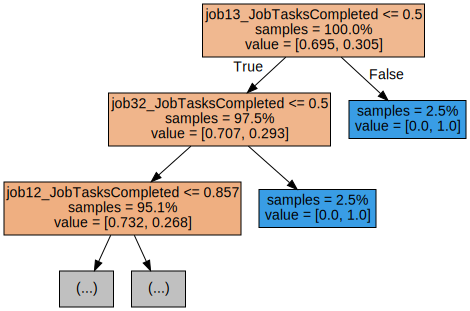

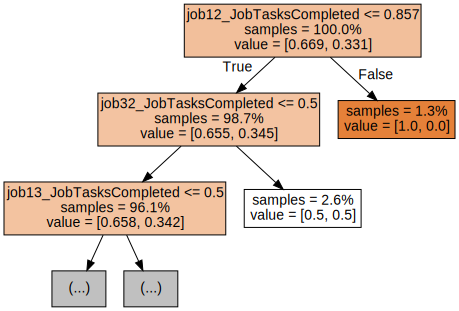

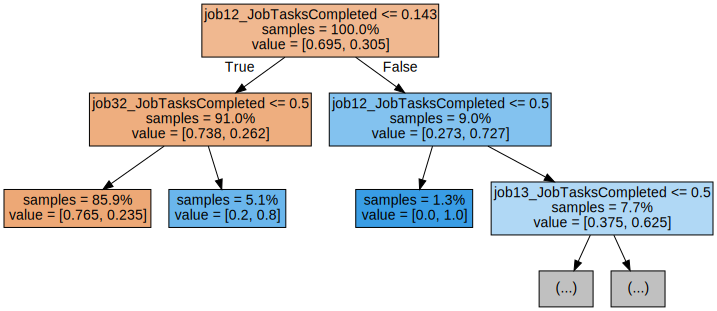

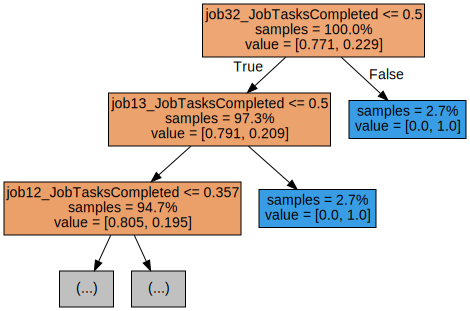

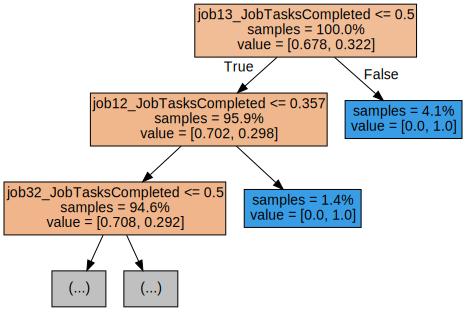

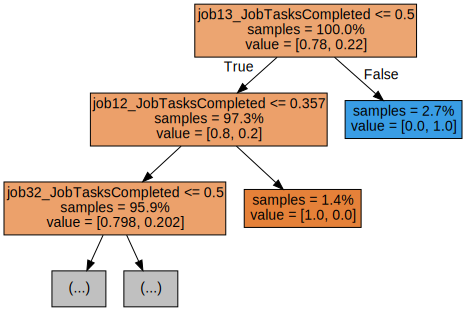

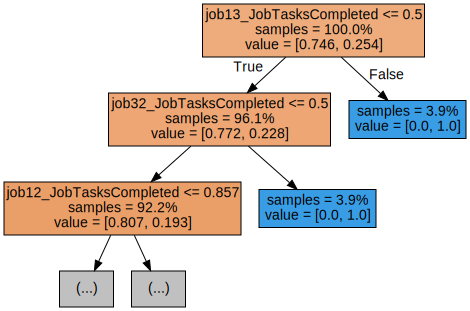

In [ ]:
for i in range(100):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


## K-Fold cross validation
Let's try using k-fold cross validation to verify the accuracy of our model

https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/

In [ ]:
X = filtered_df[['job32_JobTasksCompleted', 'job12_JobTasksCompleted', 'job13_JobTasksCompleted']].to_numpy()
y = df_new['Argument_score_max_4_binary_bucket_3'].to_numpy()
X

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.

In [ ]:

# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [ ]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str,
            Name of the algorithm used for training e.g 'Decision Tree'

         y_label: str,
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str,
            This is the title of the plot e.g 'Accuracy Plot'

         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.

         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''

        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=0)
decision_tree_result = cross_validation(decision_tree_model, X, y, 5)
print(decision_tree_result)

{'Training Accuracy scores': array([0.78518519, 0.77037037, 0.77777778, 0.79259259, 0.78676471]), 'Mean Training Accuracy': 78.25381263616558, 'Training Precision scores': array([0.91666667, 0.88888889, 0.9       , 0.91666667, 1.        ]), 'Mean Training Precision': 0.9244444444444444, 'Training Recall scores': array([0.28205128, 0.21052632, 0.23684211, 0.28947368, 0.25641026]), 'Mean Training Recall': 0.25506072874493924, 'Training F1 scores': array([0.43137255, 0.34042553, 0.375     , 0.44      , 0.40816327]), 'Mean Training F1 Score': 0.39899226924812475, 'Validation Accuracy scores': array([0.76470588, 0.76470588, 0.76470588, 0.73529412, 0.75757576]), 'Mean Validation Accuracy': 75.73975044563281, 'Validation Precision scores': array([1.        , 0.75      , 0.75      , 1.        , 0.66666667]), 'Mean Validation Precision': 0.8333333333333334, 'Validation Recall scores': array([0.11111111, 0.3       , 0.3       , 0.1       , 0.22222222]), 'Mean Validation Recall': 0.20666666666666

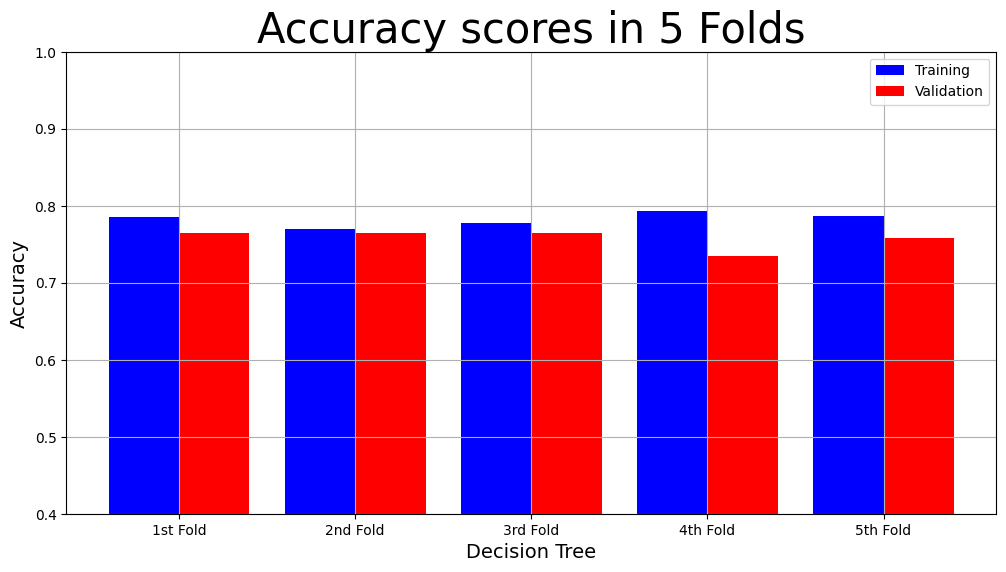

In [ ]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result["Training Accuracy scores"],
            decision_tree_result["Validation Accuracy scores"])

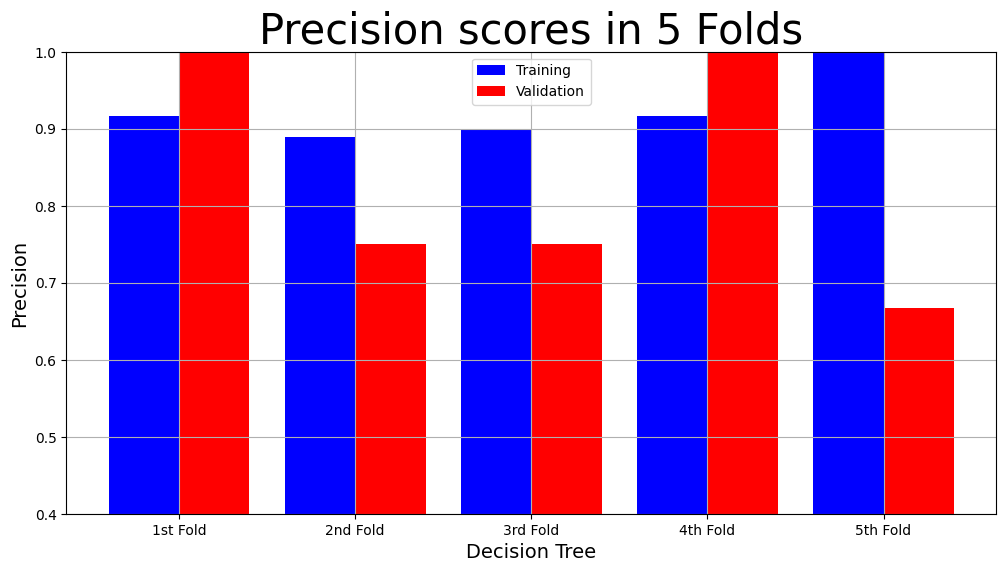

In [ ]:
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            decision_tree_result["Training Precision scores"],
            decision_tree_result["Validation Precision scores"])

In [ ]:

X = df[['job12_JobTasksCompleted']]
y = df['Argument_score_max_4_binary_bucket_2'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)


log_reg = sm.Logit(y, X).fit()

log_reg.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: ignored

Optimization terminated successfully.
         Current function value: 0.573414
         Iterations 5


Text(0, 0.5, 'Argument_score_max_4_binary_bucket_3')

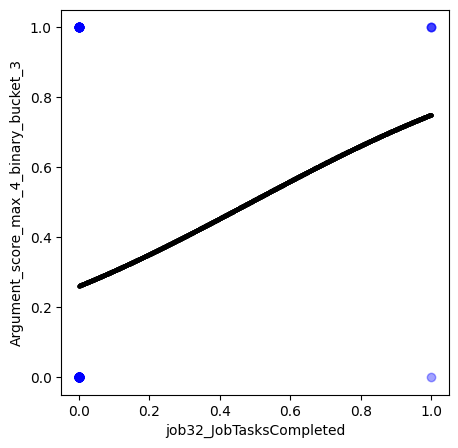

In [ ]:
res = 'job32_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

In [231]:
pred = 'job12_JobTasksCompleted + job13_JobTasksCompleted + job32_JobTasksCompleted + job20_JobTasksCompleted + job30_JobTasksCompleted + job10_JobTasksCompleted + job11_JobTasksCompleted + job14_JobTasksCompleted + job15_JobTasksCompleted + job17_JobTasksCompleted + job18_JobTasksCompleted + job19_JobTasksCompleted + job21_JobTasksCompleted + job22_JobTasksCompleted + job24_JobTasksCompleted + job25_JobTasksCompleted + job26_JobTasksCompleted + job27_JobTasksCompleted + job28_JobTasksCompleted + job29_JobTasksCompleted + job32_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{res} ~ {pred}', data=df_new).fit()

log_reg.summary()

         Current function value: 0.454979
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Logit Regression Results                                    
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   No. Observations:                  169
Model:                                            Logit   Df Residuals:                      148
Method:                                             MLE   Df Model:                           20
Date:                                  Tue, 01 Aug 2023   Pseudo R-squ.:                  0.2375
Time:                                          19:37:07   Log-Likelihood:                -76.891
converged:                                        False   LL-Null:                       -100.84
Covariance Type:                              nonrobust   LLR p-value:                 0.0004385
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0903      0.284     -3.845      0.000      -1.646      -0.535
job12_JobTasksCompleted    23.2181     17.424      1.333      0.183     -10.932      57.369
job13_JobTasksCompleted    -0.3813      2.843     -0.134      0.893      -5.953       5.190
job32_JobTasksCompleted    39.4239   2.71e+04      0.001      0.999   -5.31e+04    5.32e+04
job20_JobTasksCompleted     0.9463      1.130      0.837      0.402      -1.268       3.161
job30_JobTasksCompleted    20.2274   3.55e+04      0.001      1.000   -6.95e+04    6.95e+04
job10_JobTasksCompleted    -1.0479      1.845     -0.568      0.570      -4.664       2.568
job11_JobTasksCompleted     0.2071      2.913      0.071      0.943      -5.503       5.917
job14_JobTasksCompleted    -1.6648      1.228     -1.355      0.175      -4.072       0.743
job15_JobTasksCompleted   -20.8808     14.595     -1.431      0.153     -49.487       7.725
job17_JobTasksCompleted     2.7101      1.958      1.384      0.166      -1.127       6.547
job18_JobTasksCompleted    -1.4141      3.276     -0.432      0.666      -7.835       5.007
job19_JobTasksCompleted     5.6863      4.507      1.262      0.207      -3.148      14.520
job21_JobTasksCompleted     1.3816      0.850      1.626      0.104      -0.284       3.047
job22_JobTasksCompleted     0.5384      1.683      0.320      0.749      -2.760       3.837
job24_JobTasksCompleted    -0.2807      0.580     -0.484      0.628      -1.418       0.856
job25_JobTasksCompleted    -0.7885      0.600     -1.314      0.189      -1.965       0.388
job26_JobTasksCompleted     0.0277      1.316      0.021      0.983      -2.551       2.606
job27_JobTasksCompleted   -28.6695   3.72e+04     -0.001      0.999   -7.29e+04    7.28e+04
job28_JobTasksCompleted    -1.3147      1.999     -0.658      0.511      -5.233       2.604
job29_JobTasksCompleted   -36.0453   2.71e+04     -0.001      0.999   -5.32e+04    5.31e+04
===========================================================================================
"""

In [210]:

y = df['Argument_score_max_4_binary_bucket_3'].astype(int)

filtered_df_x = df.filter(like='JobTasksCompleted', axis=1)


# # Use iloc to select the desired columns


X_train, X_test, y_train, y_test = train_test_split(filtered_df_x, y, test_size = 0.3)


from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for X_train
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif)

high_vif_cols = vif[vif["VIF"] > 10]["Features"]


X_train = X_train.drop(columns=high_vif_cols)

log_reg = sm.Logit(y_train, X_train).fit()

log_reg.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                   Features        VIF
0    job0_JobTasksCompleted        NaN
1    job1_JobTasksCompleted   2.591948
2    job2_JobTasksCompleted   1.972517
3    job3_JobTasksCompleted        NaN
4    job4_JobTasksCompleted   2.743598
5    job5_JobTasksCompleted        NaN
6    job6_JobTasksCompleted        NaN
7    job7_JobTasksCompleted        NaN
8    job8_JobTasksCompleted        NaN
9    job9_JobTasksCompleted        NaN
10  job10_JobTasksCompleted   5.143688
11  job11_JobTasksCompleted  17.464017
12  job12_JobTasksCompleted  11.275191
13  job13_JobTasksCompleted   4.631389
14  job14_JobTasksCompleted   3.237360
15  job15_JobTasksCompleted  15.073035
16  job16_JobTasksCompleted        NaN
17  job17_JobTasksCompleted   3.277473
18  job18_JobTasksCompleted   3.381400
19  job19_JobTasksCompleted   9.287288
20  job20_JobTasksCompleted   3.355415
21  job21_JobTasksCompleted   3.541892
22  job22_JobTasksCompleted   5.158692
23  job23_JobTasksCompleted        NaN
24  job24_JobTasksComplet

LinAlgError: ignored

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                   Features        VIF
0    job0_JobTasksCompleted        NaN
1    job1_JobTasksCompleted   2.741157
2    job2_JobTasksCompleted   1.919610
3    job3_JobTasksCompleted        NaN
4    job4_JobTasksCompleted   2.350618
5    job5_JobTasksCompleted        NaN
6    job6_JobTasksCompleted        NaN
7    job7_JobTasksCompleted        NaN
8    job8_JobTasksCompleted        NaN
9    job9_JobTasksCompleted        NaN
10  job10_JobTasksCompleted   3.310028
11  job11_JobTasksCompleted   4.736126
12  job12_JobTasksCompleted   5.863523
13  job13_JobTasksCompleted   2.878474
14  job14_JobTasksCompleted   3.605605
15  job15_JobTasksCompleted   6.129978
16  job16_JobTasksCompleted        NaN
17  job17_JobTasksCompleted   3.775754
18  job18_JobTasksCompleted   4.134195
19  job19_JobTasksCompleted   3.538813
20  job20_JobTasksCompleted   2.825795
21  job21_JobTasksCompleted   3.389329
22  job22_JobTasksCompleted   4.929445
23  job23_JobTasksCompleted        NaN
24  job24_JobTasksComplet

What tripped me up:

disable sklearn regularization LogisticRegression(C=1e9)

add statsmodels intercept sm.Logit(y, sm.add_constant(X)) OR disable sklearn intercept LogisticRegression(C=1e9, fit_intercept=False)

sklearn returns probability for each class so model_sklearn.predict_proba(X)[:, 1] == model_statsmodel.predict(X)

use of predict function model_sklearn.predict(X) == (model_statsmodel.predict(X) > 0.5).astype(int)

I'm now seeing the same results in both libraries.